<a href="https://colab.research.google.com/github/sachinmathewjose/Predictive-Maintainance-Multitasklearning/blob/master/predictive_maintenance_multitaskLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


##Download data from drive

In [3]:
!cp "/content/drive/My Drive/colab/Predictive-Dataset.rar" "/content/"
!unrar x Predictive-Dataset.rar
!rm Predictive-Dataset.rar
!rm -r output
!mkdir output


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from Predictive-Dataset.rar

Creating    Predictive-Dataset                                        OK
Extracting  Predictive-Dataset/PM_test.txt                                15%  OK 
Extracting  Predictive-Dataset/PM_train.txt                               40%  OK 
Extracting  Predictive-Dataset/PM_truth.txt                               40%  OK 
Extracting  Predictive-Dataset/PredictiveManteinanceEngineTraining.csv      76%  OK 
Extracting  Predictive-Dataset/PredictiveManteinanceEngineValidation.csv      99%  OK 
All OK
rm: cannot remove 'output': No such file or directory


##Libraries

In [4]:
import keras
import tensorflow as tf
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Model,load_model, Sequential
from keras.layers import Dense, Dropout, LSTM, Input
from keras.layers.core import Lambda

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

# define path to save model
model_path = 'lstm_model.h5'

Using TensorFlow backend.


##Loading data

In [0]:
train_df = pd.read_csv('Predictive-Dataset/PM_train.txt', sep=" ", header=None)
column_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = column_names
train_df = train_df.sort_values(['id','cycle'])

test_df = pd.read_csv('Predictive-Dataset/PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = column_names
truth_df = pd.read_csv('Predictive-Dataset/PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)


In [6]:
train_df.describe()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,21.609803,553.367711,2388.096652,9065.242941,1.300000e+00,47.541168,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,0.001389,0.885092,0.070985,22.082880,4.660829e-13,0.267087,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,21.600000,549.850000,2387.900000,9021.730000,1.300000e+00,46.850000,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,21.610000,552.810000,2388.050000,9053.100000,1.300000e+00,47.350000,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,21.610000,553.440000,2388.090000,9060.660000,1.300000e+00,47.510000,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,21.610000,554.010000,2388.140000,9069.420000,1.300000e+00,47.700000,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,21.610000,556.060000,2388.560000,9244.590000,1.300000e+00,48.530000,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


####PREPROCESSING

In [0]:
# generate label columns for training data for RUL
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

# generate label columns for training data for FP
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

train_df.to_csv('Predictive-Dataset/PredictiveManteinanceEngineTraining.csv', encoding='utf-8',index = None)


In [8]:
# TEST DATASET
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
print(test_df.head())

rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

test_df.to_csv('Predictive-Dataset/PredictiveManteinanceEngineValidation.csv', encoding='utf-8',index = None)

   id  cycle  setting1  setting2  ...  s19       s20       s21  cycle_norm
0   1      1  0.632184  0.750000  ...  0.0  0.558140  0.661834     0.00000
1   1      2  0.344828  0.250000  ...  0.0  0.682171  0.686827     0.00277
2   1      3  0.517241  0.583333  ...  0.0  0.728682  0.721348     0.00554
3   1      4  0.741379  0.500000  ...  0.0  0.666667  0.662110     0.00831
4   1      5  0.580460  0.500000  ...  0.0  0.658915  0.716377     0.01108

[5 rows x 27 columns]


In [0]:
sequence_length = 50

# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used"""
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)


In [10]:
#val=list(gen_sequence(train_df[train_df['id']==1], sequence_length, sequence_cols))
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

# function to generate labels
def gen_labels(id_df, seq_length, label):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # For one id I put all the labels in a single matrix.
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL','label1']) 
             for id in train_df['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 50, 25)


(15631, 2)

###MODEL

In [26]:
def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Next, we build a deep network. 
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units. 
# Dropout is also applied after each LSTM layer to control overfitting. 
# Final layer is a Dense output layer with single unit and linear activation since this is a regression problem.
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

#avoid batch processing remove overfitting
input_layer = Input(shape = (sequence_length, nb_features))
x = LSTM(units=100,return_sequences=True)(input_layer)
x = Dropout(0.2)(input_layer)
x = LSTM(units=50, return_sequences=False)(x)
x = Dropout(0.2)(x)
#x = Dense(20, activation='relu')(x)
a = Dense(1)(x)
#a = Lambda(lambda x: K.exp(x))(a)
a = Activation("linear", name="rul")(a)
b = Dense(1)(x)
b = Activation("sigmoid", name="fp")(b)
#x = Concatenate([a,b])
model = Model(inputs=input_layer, outputs=[a,b])
losses = {
	"rul": 'mean_squared_error',
	"fp": 'binary_crossentropy',
}
lossWeights = {"rul": 1.0, "fp": 10.0}
metricss = {
	"rul": ['mae',r2_keras],
	"fp": ['accuracy'],
}
model.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=metricss)
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])
# model = Sequential()
# model.add(LSTM(
#          input_shape=(sequence_length, nb_features),
#          units=100,
#          return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(
#           units=50,
#           return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(units=20))
# model.add(Dense(units=nb_out))
# model.add(Activation("linear"))
# model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 50, 25)       0                                            
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 50, 25)       0           input_5[0][0]                    
__________________________________________________________________________________________________
lstm_10 (LSTM)                  (None, 50)           15200       dropout_9[0][0]                  
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 50)           0           lstm_10[0][0]                    
__________________________________________________________________________________________________
dense_9 (D

####TRAINING

In [27]:
history = model.fit(seq_array, [np.delete(label_array,1,axis=1),np.delete(label_array,0,axis=1)], epochs=100, batch_size=200, validation_split=0.05, verbose=2, 
                    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                    keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
#callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='min'),
# list all data in history
print(history.history.keys())

Train on 14849 samples, validate on 782 samples
Epoch 1/100
 - 9s - loss: 9347.4484 - rul_loss: 9341.3084 - fp_loss: 0.6140 - rul_mean_absolute_error: 78.2504 - rul_r2_keras: -1.8813e+00 - fp_acc: 0.6895 - val_loss: 8366.3215 - val_rul_loss: 8361.2982 - val_fp_loss: 0.5024 - val_rul_mean_absolute_error: 73.0554 - val_rul_r2_keras: -2.5515e+00 - val_fp_acc: 0.8018
Epoch 2/100
 - 8s - loss: 8220.3353 - rul_loss: 8215.0041 - fp_loss: 0.5331 - rul_mean_absolute_error: 71.7032 - rul_r2_keras: -1.5295e+00 - fp_acc: 0.7950 - val_loss: 7747.8067 - val_rul_loss: 7742.8207 - val_fp_loss: 0.4986 - val_rul_mean_absolute_error: 69.4601 - val_rul_r2_keras: -2.2572e+00 - val_fp_acc: 0.8018
Epoch 3/100
 - 8s - loss: 7656.7437 - rul_loss: 7651.4706 - fp_loss: 0.5273 - rul_mean_absolute_error: 68.4292 - rul_r2_keras: -1.3589e+00 - fp_acc: 0.7963 - val_loss: 7236.2987 - val_rul_loss: 7231.3153 - val_fp_loss: 0.4983 - val_rul_mean_absolute_error: 66.5039 - val_rul_r2_keras: -2.0159e+00 - val_fp_acc: 0.801

##EVALUVATION

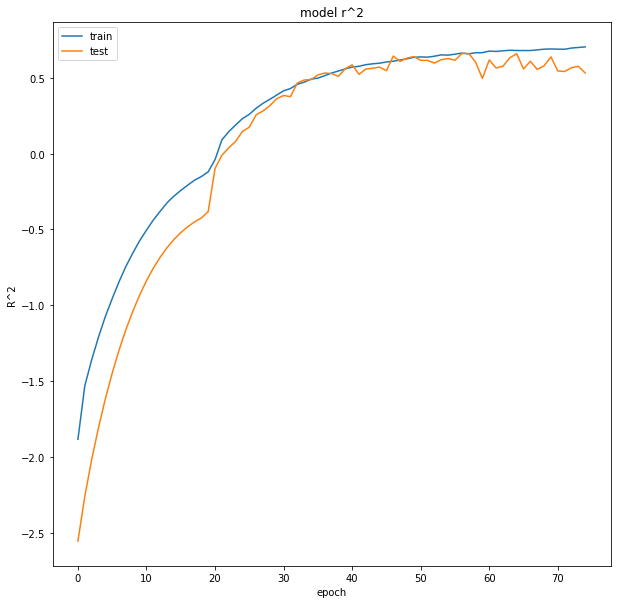

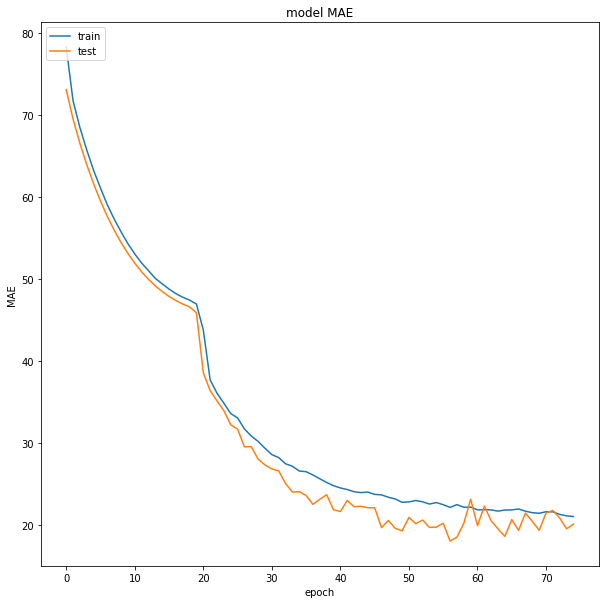

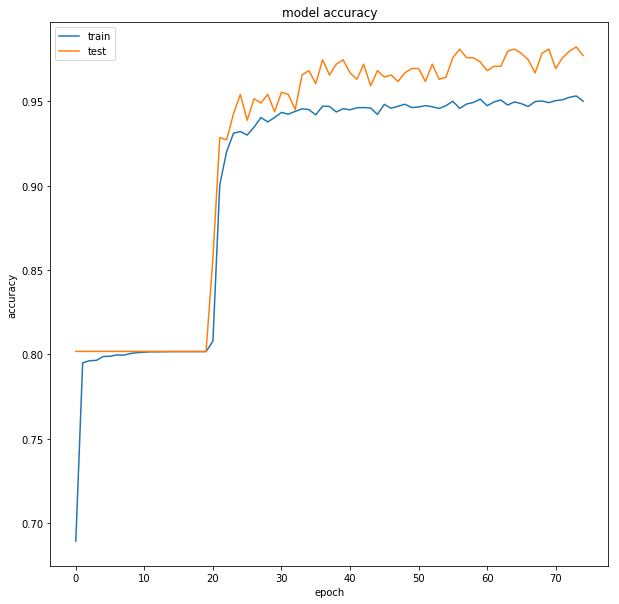

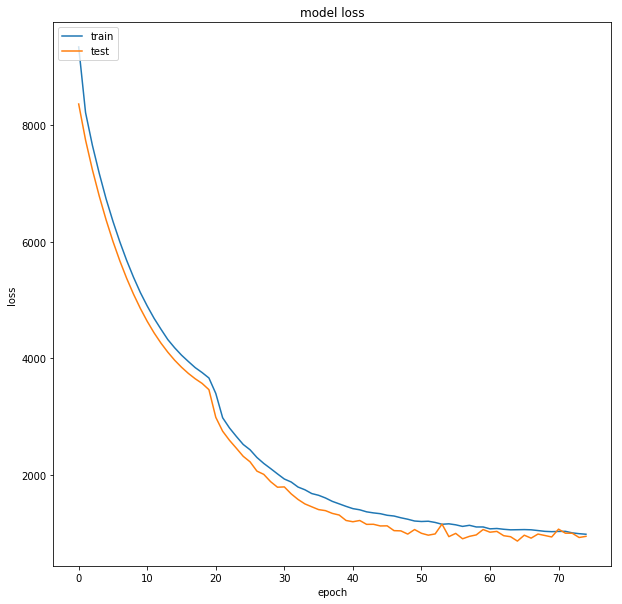

15631/15631 [==============================] - 3s 197us/step

MAE: 791.921625211016

R^2: 0.08611758569170627
Accurracy: 18.206361578046366
15631/15631 [==============================] - 3s 193us/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12301   230]
 [  231  2869]]
precision =  0.9257825104872539 
 recall =  0.925483870967742


In [31]:
## summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['rul_r2_keras'])
plt.plot(history.history['val_rul_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("output/model_r2.png")

# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['rul_mean_absolute_error'])
plt.plot(history.history['val_rul_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("output/model_mae.png")

# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['fp_acc'])
plt.plot(history.history['val_fp_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("output/model_accuracy.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("output/model_regression_loss.png")

# training metrics
scores = model.evaluate(seq_array, [np.delete(label_array,1,axis=1), np.delete(label_array,0,axis=1)],
                        verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))
print('Accurracy: {}'.format(scores[3]))

y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_true = label_array

# test_set = pd.DataFrame(np.delete(label_array,1,axis=1))
# test_set.to_csv('output/submit_train.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(np.delete(y_true,0,axis=1), y_pred[1].round())
print(cm)
# compute precision and recall
precision = precision_score(np.delete(y_true,0,axis=1), y_pred[1].round())
recall = recall_score(np.delete(y_true,0,axis=1), y_pred[1].round())
print( 'precision = ', precision, '\n', 'recall = ', recall)


In [26]:
y_pred[1]

array([[4.7868490e-04],
       [4.7272444e-04],
       [4.5767426e-04],
       ...,
       [9.9922323e-01],
       [9.9930573e-01],
       [9.9955577e-01]], dtype=float32)


MAE: 11.545093956814018

R^2: 0.8269806504249573


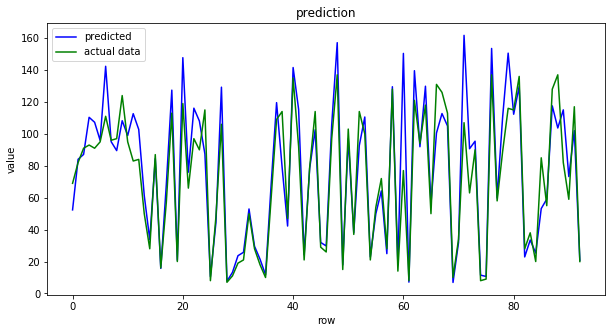

In [0]:
# We pick the last sequence for each id in the test data
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
#print("seq_array_test_last")
#print(seq_array_test_last)
#print(seq_array_test_last.shape)

# Similarly, we pick the labels
#print("y_mask")
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
#print(label_array_test_last.shape)
#print("label_array_test_last")
#print(label_array_test_last)

# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    estimator = load_model(model_path,custom_objects={'r2_keras': r2_keras})

    # test metrics
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))

    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last

    test_set = pd.DataFrame(y_pred_test)
    test_set.to_csv('output/submit_test.csv', index = None)

    # Plot in blue color the predicted data and in green color the
    # actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(10, 5))
    plt.plot(y_pred_test, color="blue")
    plt.plot(y_true_test, color="green")
    plt.title('prediction')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.show()
    fig_verify.savefig("output/model_regression_verify.png")